In [1]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
import string
import torch
import nibabel as nib
from torch.utils.data import Dataset
from torch.utils.data import random_split
import numpy as np
import os

## Obtain file names from .txt files

In [2]:
with open('training.txt') as f:
    lines = f.readlines()

In [3]:
lines[:5]

['CC0063_philips_3_53_M.nii.gz,0\n',
 'CC0063_philips_3_53_M.nii.gz,1\n',
 'CC0063_philips_3_53_M.nii.gz,2\n',
 'CC0063_philips_3_53_M.nii.gz,3\n',
 'CC0063_philips_3_53_M.nii.gz,4\n']

In [4]:
ge3_train = list(set([l.split(',')[0] for l in lines if l.split('_')[1] == 'ge']))
print("Files in GE training: ",len(ge3_train))

philips3_train = list(set([l.split(',')[0] for l in lines if l.split('_')[1] == 'philips']))
print("Files in Philips training: ",len(philips3_train))

Files in GE training:  41
Files in Philips training:  43


In [5]:
with open('validation.txt') as f:
    lines = f.readlines()
    
ge3_val = list(set([l.split(',')[0] for l in lines if l.split('_')[1] == 'ge']))
print("Files in GE val: ",len(ge3_val))

philips3_val = list(set([l.split(',')[0] for l in lines if l.split('_')[1] == 'philips']))
print("Files in Philips training: ",len(philips3_val))    

Files in GE val:  13
Files in Philips training:  11


In [6]:
with open('testing.txt') as f:
    lines = f.readlines()
     
ge3_test = list(set([l.split(',')[0] for l in lines if l.split('_')[1] == 'ge']))
print("Files in GE val: ",len(ge3_test))

philips3_test = list(set([l.split(',')[0] for l in lines if l.split('_')[1] == 'philips']))
print("Files in Philips training: ",len(philips3_test))   

Files in GE val:  6
Files in Philips training:  6


In [7]:
print("Total files in GE: ", len(ge3_train)+len(ge3_val)+len(ge3_test))
print("Total files in Philips: ", len(philips3_train)+len(philips3_val)+len(philips3_test))

Total files in GE:  60
Total files in Philips:  60


## Check intersections between splits

In [8]:
print( set(ge3_train).intersection(set(ge3_val)) )
print( set(ge3_train).intersection(set(ge3_test)) )
print( set(ge3_val).intersection(set(ge3_test)) )

set()
set()
set()


In [9]:
print( set(philips3_train).intersection(set(philips3_val)) )
print( set(philips3_train).intersection(set(philips3_test)) )
print( set(philips3_val).intersection(set(philips3_test)) )

set()
set()
set()


In [10]:
print(set(ge3_train).intersection(set(philips3_train)))
print(set(ge3_val).intersection(set(philips3_val)))
print(set(ge3_test).intersection(set(philips3_test)))

set()
set()
set()


# Pre-process and convert to numpy files

In [11]:
random_data_split = dict()

random_data_split['ge_3_train'] = ge3_train
random_data_split['ge_3_val'] = ge3_val
random_data_split['ge_3_test'] = ge3_test

random_data_split['philips_3_train'] = philips3_train
random_data_split['philips_3_val'] = philips3_val
random_data_split['philips_3_test'] = philips3_test

In [12]:
random_data_split

{'ge_3_train': ['CC0320_ge_3_57_F.nii.gz',
  'CC0308_ge_3_52_F.nii.gz',
  'CC0351_ge_3_52_M.nii.gz',
  'CC0330_ge_3_57_F.nii.gz',
  'CC0336_ge_3_53_F.nii.gz',
  'CC0306_ge_3_52_M.nii.gz',
  'CC0341_ge_3_60_M.nii.gz',
  'CC0310_ge_3_51_F.nii.gz',
  'CC0322_ge_3_59_M.nii.gz',
  'CC0317_ge_3_45_M.nii.gz',
  'CC0337_ge_3_59_F.nii.gz',
  'CC0312_ge_3_49_M.nii.gz',
  'CC0329_ge_3_58_F.nii.gz',
  'CC0318_ge_3_52_F.nii.gz',
  'CC0307_ge_3_57_M.nii.gz',
  'CC0302_ge_3_56_F.nii.gz',
  'CC0334_ge_3_45_M.nii.gz',
  'CC0321_ge_3_51_F.nii.gz',
  'CC0309_ge_3_42_M.nii.gz',
  'CC0349_ge_3_60_F.nii.gz',
  'CC0335_ge_3_54_F.nii.gz',
  'CC0333_ge_3_41_M.nii.gz',
  'CC0325_ge_3_55_F.nii.gz',
  'CC0328_ge_3_56_F.nii.gz',
  'CC0354_ge_3_61_F.nii.gz',
  'CC0343_ge_3_54_F.nii.gz',
  'CC0314_ge_3_54_M.nii.gz',
  'CC0323_ge_3_56_M.nii.gz',
  'CC0353_ge_3_58_F.nii.gz',
  'CC0319_ge_3_45_M.nii.gz',
  'CC0331_ge_3_61_F.nii.gz',
  'CC0350_ge_3_62_F.nii.gz',
  'CC0339_ge_3_59_F.nii.gz',
  'CC0347_ge_3_52_F.nii.gz',


In [13]:
def process_image(img, max_pad = 288, mode = 'original'):
    
    if mode == 'original':
        img = np.clip(np.float32(img), *np.percentile(np.float32(img), [1, 99]))
     
    '''
    MIN-MAX SCALE THE IMAGE
    '''
    assert (len(img.shape) == 3)
    assert img.min() == 0
    
    img -= np.min(img)
    img /= np.max(img)
    
    '''
    FIND NON UNIQUE AXIS AND BRING TO 0-TH POS
    '''
    vals, counts = np.unique(img.shape, return_counts = True)
    
    no_of_scans = vals[counts == 1]
    image_size = vals[counts == 2]
    
    assert (len(no_of_scans) == 1) and (len(image_size) == 1)
    img = np.swapaxes( img, 0, np.where(img.shape == no_of_scans)[0][0] )
    
    '''
    PAD IMAGE TO MAX SIZE
    '''
    pad_size = int((max_pad - image_size[0])/2)   
    
    
    return np.pad(img, pad_width = ((0, 0), (pad_size, pad_size), (pad_size, pad_size)), mode =  'constant', constant_values = 0)



In [14]:
def convert_scans_to_numpy( data_path, img_list ):
    
    original_img_path = data_path + '/Original/Original/'    
    mask_img_path = data_path + '/Silver-standard-machine-learning/Silver-standard/'

    original_images = [ process_image(nib.load(original_img_path + file).get_fdata(), mode = 'original') for file in img_list]
    mask_images = [process_image(nib.load(mask_img_path + file[:-7] + '_ss.nii.gz').get_fdata(), mode = 'mask') for file in img_list]

    print("Total number of files available:", len(original_images))

    original_images = np.concatenate( original_images , axis = 0)
    mask_images = np.concatenate( mask_images , axis = 0)
    
    return original_images, mask_images

In [15]:
data_path = 'C:/Users/rohil/Downloads/Uni Bonn/WiSe 2021-22/Lab Medical Imaging/data'

### GE 3

In [16]:
ge3_train_original, ge3_train_mask = convert_scans_to_numpy( data_path, ge3_train)

np.save('ge3_train_original_images', ge3_train_original.astype('float32'))
np.save('ge3_train_mask_images', ge3_train_mask.astype('float32'))

Total number of files available: 41


In [17]:
ge3_val_original, ge3_val_mask = convert_scans_to_numpy( data_path, ge3_val)

np.save('ge3_val_original_images', ge3_val_original.astype('float32'))
np.save('ge3_val_mask_images', ge3_val_mask.astype('float32'))

Total number of files available: 13


In [18]:
ge3_test_original, ge3_test_mask = convert_scans_to_numpy( data_path, ge3_test)

np.save('ge3_test_original_images', ge3_test_original.astype('float32'))
np.save('ge3_test_mask_images', ge3_test_mask.astype('float32'))

Total number of files available: 6


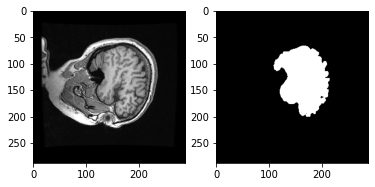

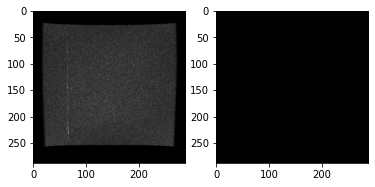

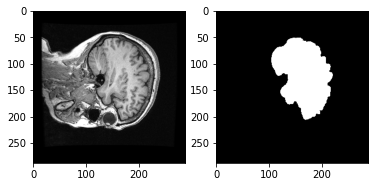

In [19]:
for i in range(3):
    index = np.random.randint(0,len(ge3_train_original), 1)
    f, axs = plt.subplots(1,2)
    axs[0].imshow( np.squeeze(ge3_train_original[index,:,:]),cmap = 'gray')
    axs[1].imshow( np.squeeze(ge3_train_mask[index,:,:]),cmap = 'gray')
    plt.pause(0.01)

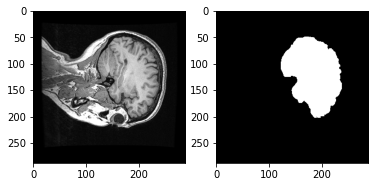

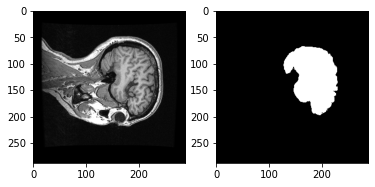

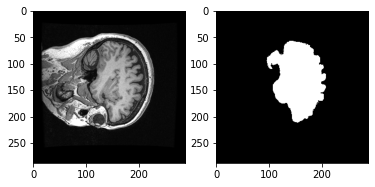

In [20]:
for i in range(3):
    index = np.random.randint(0,len(ge3_val_original), 1)
    f, axs = plt.subplots(1,2)
    axs[0].imshow( np.squeeze(ge3_val_original[index,:,:]),cmap = 'gray')
    axs[1].imshow( np.squeeze(ge3_val_mask[index,:,:]),cmap = 'gray')
    plt.pause(0.01)

### Philips 3

In [21]:
philips3_train_original, philips3_train_mask = convert_scans_to_numpy( data_path, philips3_train)

np.save('philips3_train_original_images', philips3_train_original.astype('float32'))
np.save('philips3_train_mask_images', philips3_train_mask.astype('float32'))

Total number of files available: 43


In [22]:
philips3_val_original, philips3_val_mask = convert_scans_to_numpy( data_path, philips3_val)

np.save('philips3_val_original_images', philips3_val_original.astype('float32'))
np.save('philips3_val_mask_images', philips3_val_mask.astype('float32'))

Total number of files available: 11


In [23]:
philips3_test_original, philips3_test_mask = convert_scans_to_numpy( data_path, philips3_test)

np.save('philips3_test_original_images', philips3_test_original.astype('float32'))
np.save('philips3_test_mask_images', philips3_test_mask.astype('float32'))

Total number of files available: 6


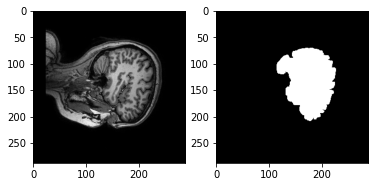

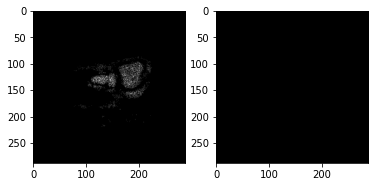

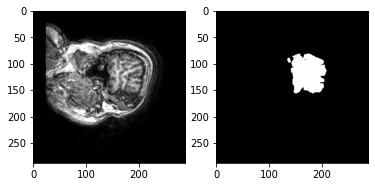

In [24]:
for i in range(3):
    index = np.random.randint(0,len(philips3_train_original), 1)
    f, axs = plt.subplots(1,2)
    axs[0].imshow( np.squeeze(philips3_train_original[index,:,:]),cmap = 'gray')
    axs[1].imshow( np.squeeze(philips3_train_mask[index,:,:]),cmap = 'gray')
    plt.pause(0.01)

### Check numpy arrays 

In [25]:
train_arr = np.load('ge3_train_original_images.npy')
m_train_arr = np.load('ge3_train_mask_images.npy')

val_arr = np.load('ge3_val_original_images.npy')
m_val_arr = np.load('ge3_val_mask_images.npy')

test_arr = np.load('ge3_test_original_images.npy')
m_test_arr = np.load('ge3_test_mask_images.npy')

In [26]:
print(train_arr.shape, m_train_arr.shape)
print(val_arr.shape, m_val_arr.shape)
print(test_arr.shape, m_test_arr.shape)

(8088, 288, 288) (8088, 288, 288)
(2552, 288, 288) (2552, 288, 288)
(1152, 288, 288) (1152, 288, 288)


In [27]:
train_arr = np.load('philips3_train_original_images.npy')
m_train_arr = np.load('philips3_train_mask_images.npy')

val_arr = np.load('philips3_val_original_images.npy')
m_val_arr = np.load('philips3_val_mask_images.npy')

test_arr = np.load('philips3_test_original_images.npy')
m_test_arr = np.load('philips3_test_mask_images.npy')

In [28]:
print(train_arr.shape, m_train_arr.shape)
print(val_arr.shape, m_val_arr.shape)
print(test_arr.shape, m_test_arr.shape)

(7740, 288, 288) (7740, 288, 288)
(1980, 288, 288) (1980, 288, 288)
(1080, 288, 288) (1080, 288, 288)
